# L2: Data Exploration for Tuning a Foundation Model

**Project environment setup:**

- Load credentials and relevant Python Libraries
- If you were running this notebook locally, you would first install Vertex AI. In this classroom, this is already installed.

```
!pip install google-cloud-aiplatform
```
- You can download the `requirements.txt` for this course from the workspace of this lab. `File --> Open...`

In [1]:
from utils import authenticate
credentials, PROJECT_ID = authenticate() 

In [2]:
REGION = "us-central1"

- Import the [Vertex AI](https://cloud.google.com/vertex-ai) SDK.
- The library helps to interact with the Vertex AI services in the cloud.
- Initialize it. 

In [3]:
import vertexai

In [4]:
vertexai.init(project = PROJECT_ID,
              location = REGION,
              credentials = credentials)

- Import [BigQuery](https://cloud.google.com/bigquery) to use as your data warehouse.
- Initialize the client to start interacting with the data warehouse, send SQL and retrieve data into the notebook.

In [5]:
from google.cloud import bigquery

In [6]:
bq_client = bigquery.Client(project=PROJECT_ID,
                            credentials = credentials)

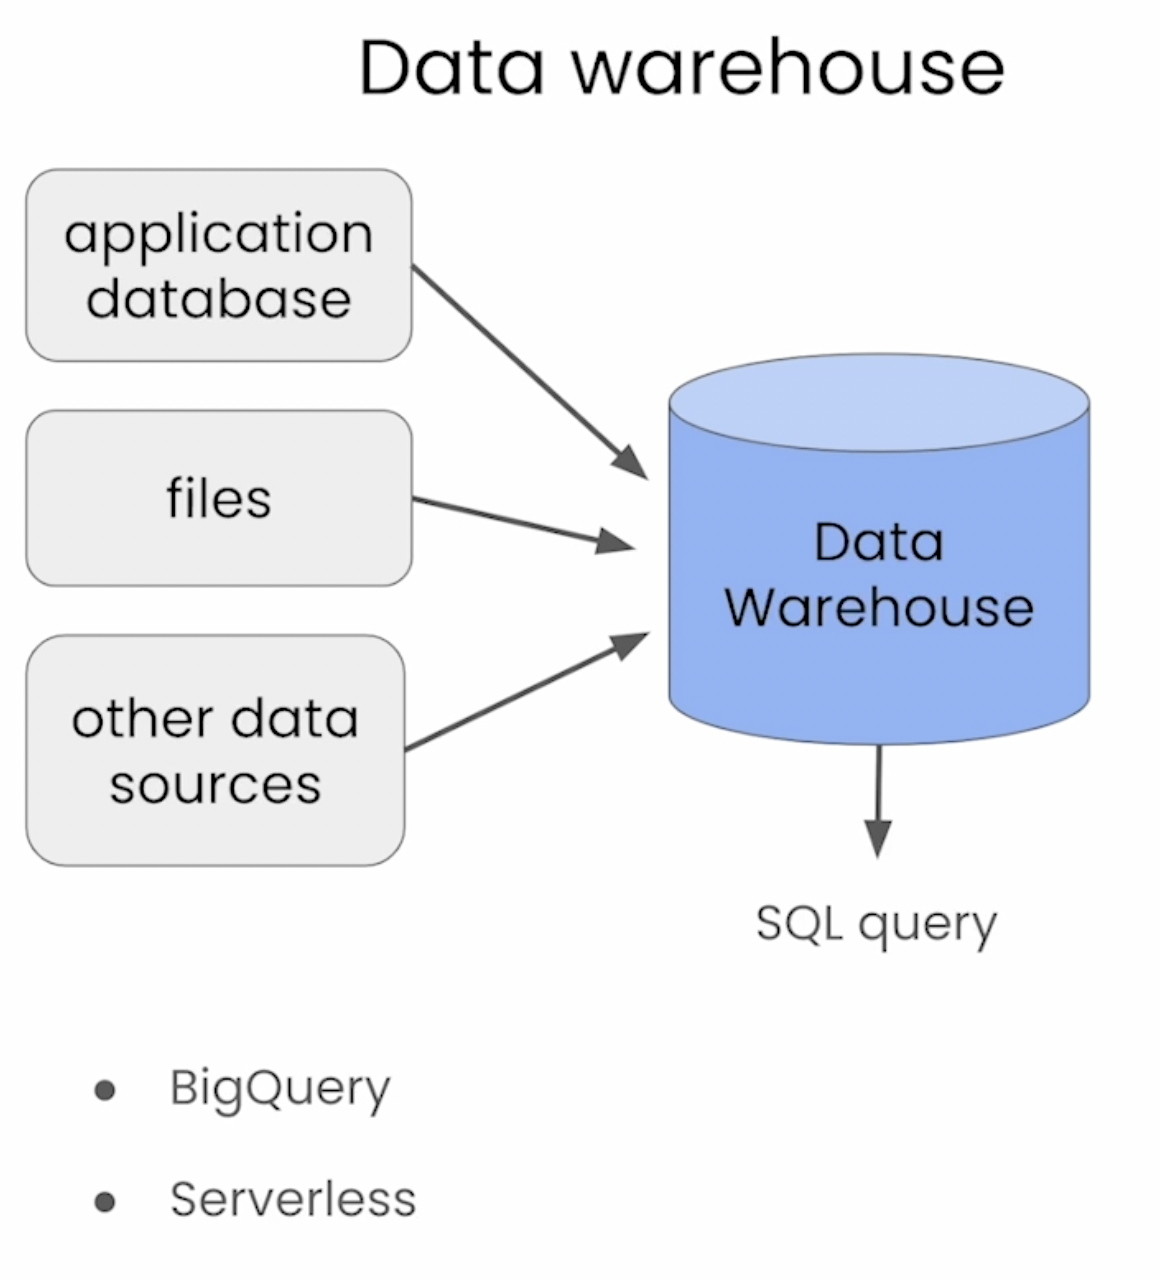

## Stack Overflow Public Dataset

- You will use [Stack Overflow Data](https://cloud.google.com/blog/topics/public-datasets/google-bigquery-public-datasets-now-include-stack-overflow-q-a) on BigQuery Public Datasets.
- The datasets include questions, answers and metadata related to Stack Overflow questions. Within this dataset, there are tables with data.
- Create a SQL query.

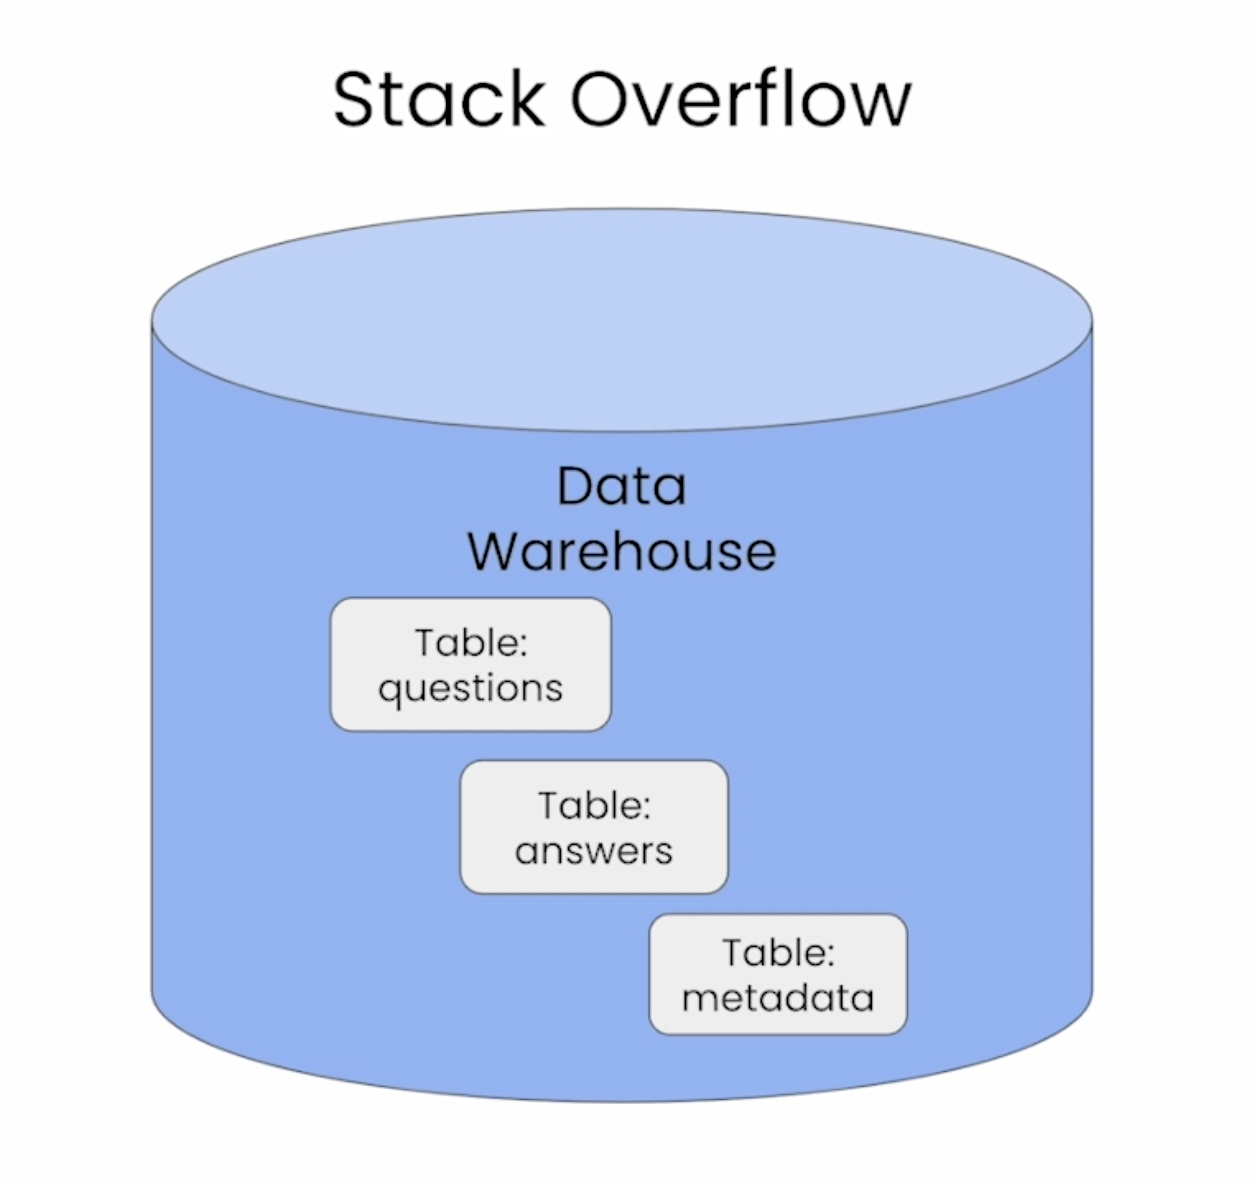

In [7]:
QUERY_TABLES = """
SELECT
  table_name
FROM
  `bigquery-public-data.stackoverflow.INFORMATION_SCHEMA.TABLES`
"""

- The query is asking to retrieve `table_name` of all the `TABLES`
- Use the client to send your SQL and retrieve the data (tables names).

In [8]:
query_job = bq_client.query(QUERY_TABLES)

In [9]:
for row in query_job:
    for value in row.values():
        print(value)

posts_answers
users
posts_orphaned_tag_wiki
posts_tag_wiki
stackoverflow_posts
posts_questions
comments
posts_tag_wiki_excerpt
posts_wiki_placeholder
posts_privilege_wiki
post_history
badges
post_links
tags
votes
posts_moderator_nomination


## Data Retrieval

- You'll fetch some data from the data warehouse and store it in Pandas dataframe for visualization.
- Select all columns from  `posts_questions` and put the `LIMIT` as 3.

In [10]:
INSPECT_QUERY = """
SELECT
    *
FROM
    `bigquery-public-data.stackoverflow.posts_questions`
LIMIT 3
"""

In [11]:
import pandas as pd

In [12]:
query_job = bq_client.query(INSPECT_QUERY)

- Take the results of the query `-->` create an arrow table (which is part of [Apache Framework](https://arrow.apache.org/docs/index.html)) `-->` which goes into a Pandas dataframe.
- This allows for data to be in a format which is easier to read and explore with Pandas.

In [13]:
stack_overflow_df = query_job\
    .result()\
    .to_arrow()\
    .to_pandas()
stack_overflow_df.head()

,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags,view_count
0,3227205,how to send more than three variables by using...,"<p>how can i send 3 text box,1 select button v...",NaN,0,0,None,2010-07-12T09:24:01.383Z,0,2010-07-12T09:52:52.373Z,2010-07-12T09:25:48.027Z,None,47738.0,None,386361,None,1,0,html,116
1,3232809,bitshift equivalent of math.round,<p>(Math.round(var/var1)*var1)</p>\n\n<p>What ...,NaN,0,0,None,2010-07-12T22:34:26.247Z,0,2010-07-13T00:00:32.173Z,2010-07-13T00:00:32.173Z,None,354992.0,None,354992,None,1,0,javascript,193
2,3233785,Recurrence Relation: Finding Big O,<p>I'm trying to find Big O of this recurrence...,3233913.0,0,0,None,2010-07-13T02:28:59.343Z,0,2010-07-13T03:38:48.777Z,None,None,NaN,None,388991,None,1,0,big-o|recurrence,528


### Dealing with Large Datasets

- Large datasets for LLMs often don't fit into memory.
- Select all of the columns and rows of the table `posts_questions`.

In [14]:
QUERY_ALL = """
SELECT
    *
FROM
    `bigquery-public-data.stackoverflow.posts_questions` q
"""

In [15]:
query_job = bq_client.query(QUERY_ALL)

In [16]:
try:
    stack_overflow_df = query_job\
    .result()\
    .to_arrow()\
    .to_pandas()
except Exception as e:
    print('The DataFrame is too large to load into memory.', e)

The DataFrame is too large to load into memory. 403 Response too large to return. Consider specifying a destination table in your job configuration. For more details, see https://cloud.google.com/bigquery/troubleshooting-errors

Location: US
Job ID: dcce3ae3-7b00-48ac-b585-eaec0b0260f1



**Note:** The data is too large to return, as it is not fitting into memory.

#### Joining Tables and Query Optimization

- When working with (large) data, query optimizing is needed in order to save time and resources.
- Select questions as `input_text` (column 1), answers as `output_text` (column 2).
- Take the questions from `posts_questions` and answers from `posts_answers`.
- Join the questions and their corresponding accepted answers based on their same `unique ID`.
- Making sure the question is about `Python`, and that it `has an answer`. And the date the question was posted is on or after `2020-01-01`
- Limit as 10,000

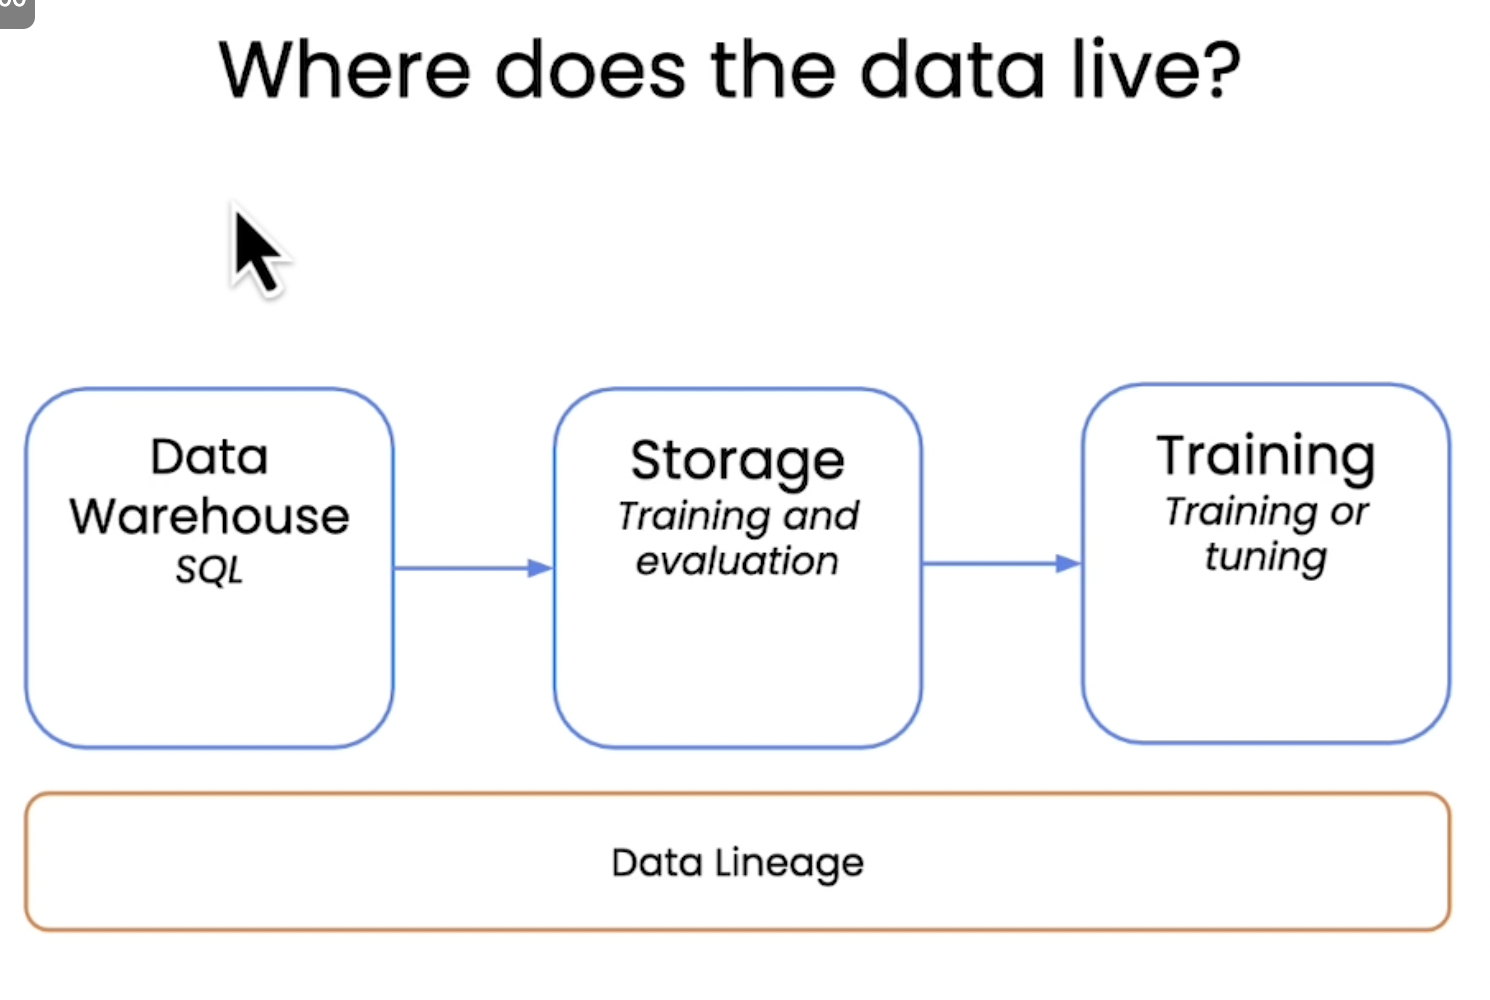

When we have 2 large tables in the data warehouse and you want to do joining or filtering, then the best thing to do is SQL in your data warehouse in order to deal with these large data instead of exporting. 

Working with large data we have to optimize the query to save resources; so here we will be combine 2 tables to get a question and the answer we need for tuning.

In [17]:
QUERY = """
SELECT
    CONCAT(q.title, q.body) as input_text,
    a.body AS output_text
FROM
    `bigquery-public-data.stackoverflow.posts_questions` q
JOIN
    `bigquery-public-data.stackoverflow.posts_answers` a
ON
    q.accepted_answer_id = a.id
WHERE
    q.accepted_answer_id IS NOT NULL AND
    REGEXP_CONTAINS(q.tags, "python") AND
    a.creation_date >= "2020-01-01"
LIMIT
    10000
"""

In [18]:
query_job = bq_client.query(QUERY)

In [19]:
### this may take some seconds to run
stack_overflow_df = query_job.result()\
                        .to_arrow()\
                        .to_pandas()

stack_overflow_df.head(2)

,input_text,output_text
0,Implementing Kalman filter in Python - are the...,"<p>Your covariance update appears correct, but..."
1,Getting the value in a field in the json objec...,"<pre class=""lang-py prettyprint-override""><cod..."


### Adding Instructions

- Instructions for LLMs have been shown to improve
model performance and generalization to unseen tasks [(Google, 2022)](https://arxiv.org/pdf/2210.11416.pdf).
- Wihtout the instruction, it is only question and answer. Model might not understand what to do.
- With the instructions, the model gets a guideline as to what task to perform.

In [20]:
INSTRUCTION_TEMPLATE = f"""\
Please answer the following Stackoverflow question on Python. \
Answer it like you are a developer answering Stackoverflow questions.

Stackoverflow question:
"""

- A new column will combine `INSTRUCTION_TEMPLATE` and the question `input_text`.
- This avoids overwritting of any existing column which might be needed.

In [21]:
stack_overflow_df['input_text_instruct'] = INSTRUCTION_TEMPLATE + ' '\
    + stack_overflow_df['input_text']

### Dataset for Tuning

- Divide the data into a training and evaluation. By default, 80/20 split is used.
- This (80/20 split) allows for more data to be used for tuning. The evaluation split is used as unseen data during tuning to evaluate performance.
- The `random_state` parameter is used to ensure random sampling for a fair comparison. 

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
train, evaluation = train_test_split(
    stack_overflow_df,
    ### test_size=0.2 means 20% for evaluation
    ### which then makes train set to be of 80%
    test_size=0.2,
    random_state=42
)

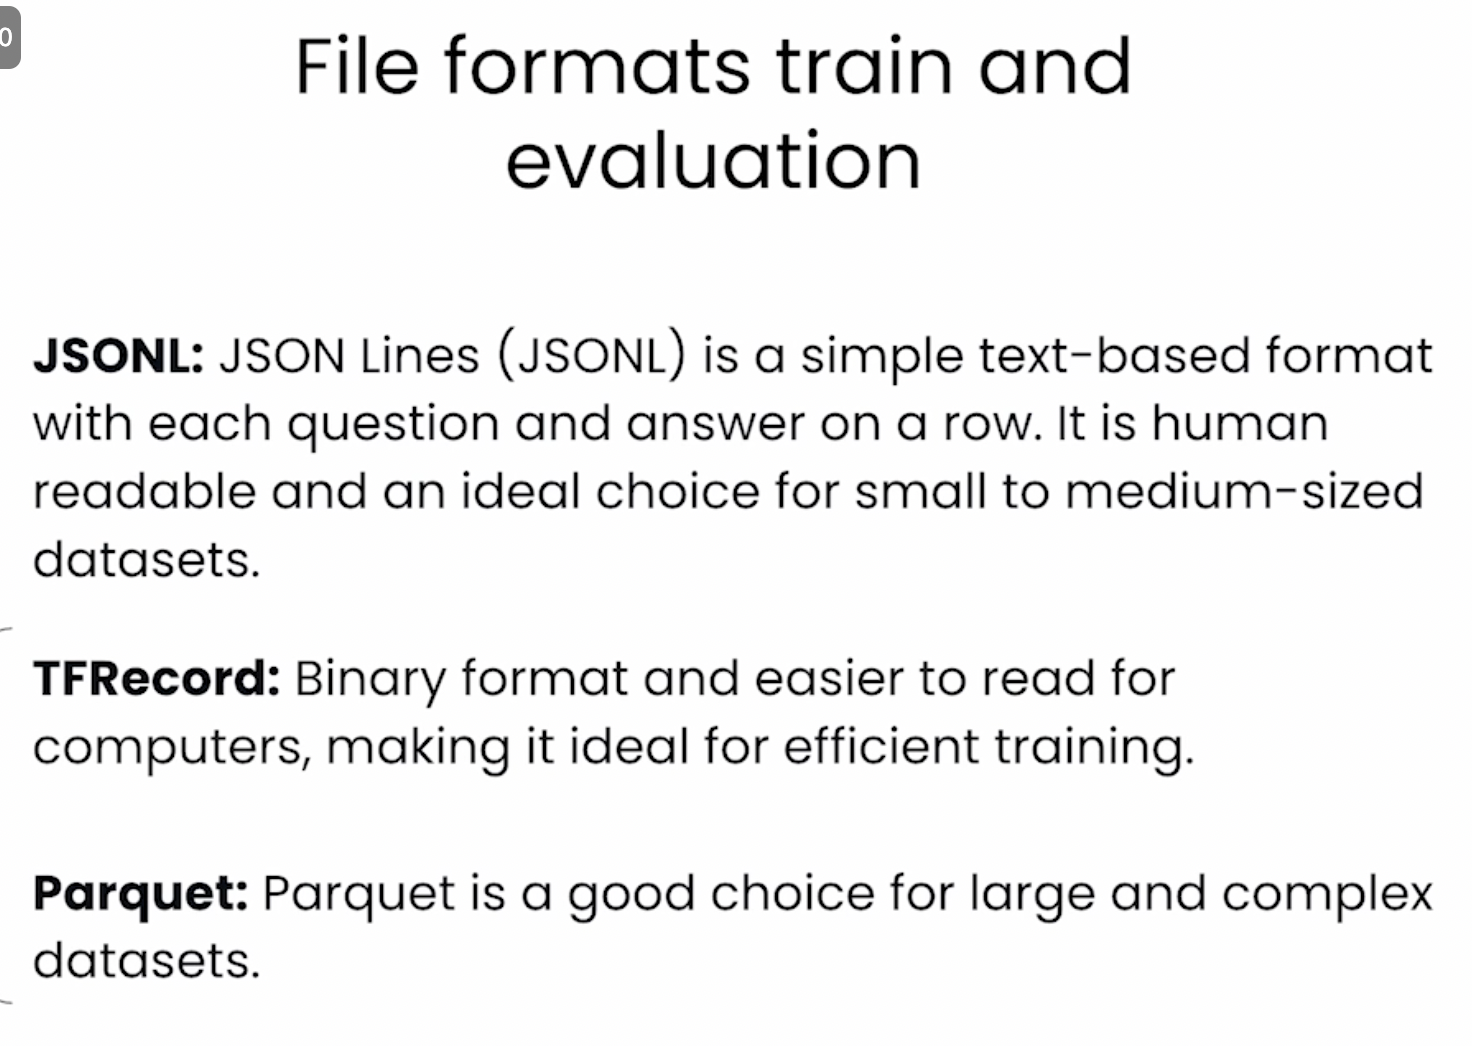

#### Different Datasets and Flow

- Versioning data is important.
- It allows for reproducibility, traceability, and maintainability of machine learning models.
- Get the timestamp.

In [24]:
import datetime

In [25]:
date = datetime.datetime.now().strftime("%H:%d:%m:%Y")

- Generate a `jsonl` file.
- Name it as `tune_data_stack_overflow_python_qa-{date}`

In [26]:
cols = ['input_text_instruct','output_text']
tune_jsonl = train[cols].to_json(orient="records", lines=True)

In [27]:
training_data_filename = f"tune_data_stack_overflow_\
                            python_qa-{date}.jsonl"

In [28]:
with open(training_data_filename, "w") as f:
    f.write(tune_jsonl)

## Try it Yourself! - Evaluation Set

The code above generted a `jsonl` file for the `train` set. Now, its time for you to make the `evaluation` set, which you can name as `tune_eval_data_stack_overflow_python_qa-{date}.jsonl`. The code for that is also provided to you in the drop down below, but we encourage you to try it yourself first before you look at it.

<details>
  <summary><font size="2" color="darkgreen"><b>Code for Evaluation Set (Click to expand)</b></font></summary>
    
```python

cols = ['input_text_instruct','output_text']
### you need to use the "evaluation" set now
tune_jsonl = evaluation[cols].to_json(orient="records", lines=True)

### change the file name
### use "tune_eval_data_stack_overflow_python_qa-{date}.jsonl"
evaluation_data_filename = f"tune_eval_data_stack_overflow_\
                            python_qa-{date}.jsonl"

### write the file
with open(evaluation_data_filename, "w") as f:
    f.write(tune_jsonl)

```

In [29]:
cols = ['input_text_instruct','output_text']
### you need to use the "evaluation" set now
tune_jsonl = evaluation[cols].to_json(orient="records", lines=True)

### change the file name
### use "tune_eval_data_stack_overflow_python_qa-{date}.jsonl"
evaluation_data_filename = f"tune_eval_data_stack_overflow_\
                            python_qa-{date}.jsonl"

### write the file
with open(evaluation_data_filename, "w") as f:
    f.write(tune_jsonl)
